In [251]:
import simpy
import random
import numpy as np
from collections import deque
from scipy.special import gamma
import matplotlib.pyplot as plt

In [252]:
class ArrivalProcesses:
    COMPOUND = 1
    RENEWAL = 2
    SCHEDULED = 3

In [253]:
# Simulation Parameters:
NUM_TRUCKS = 20
NUM_CHARGERS = 200
NUM_TESTERS = 35
BATCH_SIZE = 20
TEST_TIME = 0
TRANSFER_TIME = 1  # Time taken to transfer a batch to the chargers
TRUCK_CAPACITY = [20, 40]
BATTERY_MEAN = 20 # Mean(#batteries) carried in a truck

# Process Parameters:
ARRIVAL_PROCESS = ArrivalProcesses.SCHEDULED
SIM_PERIOD = 240 # A period of all truck arrivals
ARRIVAL_RATE = NUM_TRUCKS / SIM_PERIOD
SHAPE_PARAMETER = 2
SCALE_PARAMETER = (SIM_PERIOD // NUM_TRUCKS) / gamma(1 + 1 / SHAPE_PARAMETER)
SCHEDULED_BATCH_SIZE = 4 # Number of trucks in each batch
SCHEDULED_BATCH_WINDOW = 20 # Time window for each batch to arrive
SCHEDULED_BATCH_INTERVAL = SIM_PERIOD // (NUM_TRUCKS // SCHEDULED_BATCH_SIZE) # Time between batches


# Global Counters and Indexes
global_battery_index = 0 
stage_1_cnt = 0
stage_2_cnt = 0


# Buffers 
test_buffer = None
fully_charged_buffer = None
road_buffer = None
truck_buffer = None



# Logs
test_queue_over_time = []
ccs_queue_over_times = [] 
stage_counts_over_time = []
fb_buffer_over_time = []  # for fully charged buffer

truck_battery_queue = deque() # for trucks arriving at CCS

In [254]:
class Battery:
    def __init__(self, idx):
        global global_battery_index
        self.name = f"Battery {idx}"
        global_battery_index += 1

    def test_and_transfer(self, env, testers, batch_queue):
        global test_queue_over_time , TEST_TIME

        with testers.request() as test_req:
            yield test_req
            print(f'{self.name} starts testing at {env.now}')
            yield env.timeout(TEST_TIME)
            # yield env.timeout(random.randint(1, 2))  # Testing time between 1 and 2
            test_queue_over_time.append((env.now, len(testers.queue)))
            print(f'{self.name} ends testing at {env.now}')
  
        yield batch_queue.put(self)

    def charge(self, env, chargers):
        # Battery charging process
        global stage_1_cnt, stage_2_cnt, stage_counts_over_time, ccs_queue_over_times, fully_charged_buffer, fb_buffer_over_time

        print(f'{self.name} arrives for charging at {env.now}')
        ccs_queue_over_times.append((env.now, len(chargers.queue)))
        with chargers.request() as req:   # 
            
            yield req

            # Constant-current phase
            start_cc_service = env.now
            print(f'{self.name} starts constant-current charging at {start_cc_service}')
            cc_charging_time = random.randint(30, 120) # Gamma() powerfamily distri
            stage_1_cnt += 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            yield env.timeout(cc_charging_time)
            stage_1_cnt -= 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            print(f'{self.name} ends constant-current charging at {env.now}')
            yield env.timeout(1)  # Small delay before starting CV stage

            # Constant-voltage phase
            start_cv_service = env.now
            print(f'{self.name} starts constant-voltage charging at {start_cv_service}')
            cv_charging_time = random.randint(20, 40)
            stage_2_cnt += 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            yield env.timeout(cv_charging_time)
            stage_2_cnt -= 1
            stage_counts_over_time.append((env.now, stage_1_cnt, stage_2_cnt, stage_1_cnt + stage_2_cnt))
            print(f'{self.name} ends constant-voltage charging at {env.now}')

        yield fully_charged_buffer.put(self)
        ccs_queue_over_times.append((env.now, len(chargers.queue)))
        fb_buffer_over_time.append((env.now, len(fully_charged_buffer.items)))
        print(f'{self.name} stored in the fully charged buffer at {env.now}')


In [255]:
def process_truck_arrival(env, battery_mean, truck_size):
    global test_buffer, fully_charged_buffer, truck_battery_queue
    num_batteries = np.random.poisson(battery_mean)
    num_batteries = min(num_batteries, truck_size)
    truck_battery_queue.append(num_batteries)
    for _ in range(num_batteries):
        battery = Battery(global_battery_index)
        yield test_buffer.put(battery)
    print(f'Truck (size {truck_size}) arrived with {num_batteries} depleted batteries at {env.now:.2f} minutes')

def process_truck_loading(env):
    global test_buffer, fully_charged_buffer, truck_battery_queue 
    while True:
        while truck_battery_queue:
            num_batteries_needed = truck_battery_queue.popleft()
            print(f'Need {num_batteries_needed} batteries.')

            while num_batteries_needed > len(fully_charged_buffer.items):
                # Wait if there are not enough charged batteries in the loading buffer
                yield env.timeout(1)

            for _ in range(num_batteries_needed):
                battery = yield fully_charged_buffer.get()
            
            print(f'Truck loaded with {num_batteries_needed} charged batteries and left at {env.now:.2f} minutes. Now {len(fully_charged_buffer.items)} batteries in the loading buffer.')

        yield env.timeout(1)

def truck_arrival_compound_poisson(env, battery_mean, arrival_rate):
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        truck_size = random.choice(TRUCK_CAPACITY)
        env.process(process_truck_arrival(env, battery_mean, truck_size))

def truck_arrival_renewal(env, battery_mean, scale_parameter, shape_parameter):
    while True:
        yield env.timeout(random.weibullvariate(scale_parameter, shape_parameter))
        truck_size = random.choice(TRUCK_CAPACITY)
        env.process(process_truck_arrival(env, battery_mean, truck_size))

def scheduled_batched_arrival(env, battery_mean, batch_size, batch_interval, batch_window):
    start_time = 0
    while True:
        arrival_times = [random.uniform(start_time, start_time + batch_window) for _ in range(batch_size)]
        arrival_times.sort()
        
        for arrival_time in arrival_times:
            yield env.timeout(arrival_time - env.now)
            truck_size = random.choice(TRUCK_CAPACITY)
            env.process(process_truck_arrival(env, battery_mean, truck_size))

        yield env.timeout(start_time + batch_interval - env.now)
        start_time += batch_interval


In [256]:
def battery_transfer_warehouse(env, batch_queue, chargers, transfer_time):
    # charges batteries from batch_queue in batches
    while True:
        batch = []
        while len(batch) < BATCH_SIZE:
            battery = yield batch_queue.get()
            batch.append(battery)

        yield env.timeout(transfer_time)

        for battery in batch:
            env.process(battery.charge(env, chargers))

In [257]:
def initialize_charging_station(env, testers, chargers):
    global global_battery_index, batch_queue, test_buffer, ccs_queue_over_times, fb_buffer_over_time
    global test_queue_over_time

    for _ in range(int(NUM_TRUCKS * BATTERY_MEAN)):
        battery = Battery(global_battery_index)
        fully_charged_buffer.put(battery)
    
    while True:
        # test batteries from test_buffer and put into batch_queue
        if len(test_buffer.items) > 0 :
            while len(test_buffer.items) > 0 :
                battery = yield test_buffer.get()
                yield env.process(battery.test_and_transfer(env, testers, batch_queue)) 
                # print("tested")
        else:
            yield env.timeout(1)

        test_queue_over_time.append((env.now, len(testers.queue)))
        fb_buffer_over_time.append((env.now, len(fully_charged_buffer.items))) 
        ccs_queue_over_times.append((env.now, len(chargers.queue)))


In [258]:
env = simpy.Environment()
testers = simpy.Resource(env, capacity=NUM_TESTERS)
chargers = simpy.Resource(env, capacity=NUM_CHARGERS)
batch_queue = simpy.Store(env)
fully_charged_buffer = simpy.Store(env)
test_buffer = simpy.Store(env)

env.process(initialize_charging_station(env, testers, chargers))
env.process(battery_transfer_warehouse(env, batch_queue, chargers, TRANSFER_TIME))
env.process(process_truck_loading(env))

if ARRIVAL_PROCESS == ArrivalProcesses.COMPOUND:
    env.process(truck_arrival_compound_poisson(env, BATTERY_MEAN, ARRIVAL_RATE))
elif ARRIVAL_PROCESS == ArrivalProcesses.RENEWAL:
    env.process(truck_arrival_renewal(env, BATTERY_MEAN, SCALE_PARAMETER, SHAPE_PARAMETER))
elif ARRIVAL_PROCESS == ArrivalProcesses.SCHEDULED:
    env.process(scheduled_batched_arrival(env, BATTERY_MEAN, SCHEDULED_BATCH_SIZE, SCHEDULED_BATCH_INTERVAL, SCHEDULED_BATCH_WINDOW))


env.run(until=2*24*60)
# env.run(until=SIM_PERIOD)

Truck (size 40) arrived with 13 depleted batteries at 2.22 minutes
Need 13 batteries.
Battery 400 starts testing at 3
Battery 400 ends testing at 3
Battery 401 starts testing at 3
Battery 401 ends testing at 3
Battery 402 starts testing at 3
Battery 402 ends testing at 3
Truck loaded with 13 charged batteries and left at 3.00 minutes. Now 387 batteries in the loading buffer.
Battery 403 starts testing at 3
Battery 403 ends testing at 3
Battery 404 starts testing at 3
Battery 404 ends testing at 3
Battery 405 starts testing at 3
Battery 405 ends testing at 3
Battery 406 starts testing at 3
Battery 406 ends testing at 3
Battery 407 starts testing at 3
Battery 407 ends testing at 3
Battery 408 starts testing at 3
Battery 408 ends testing at 3
Battery 409 starts testing at 3
Battery 409 ends testing at 3
Battery 410 starts testing at 3
Battery 410 ends testing at 3
Battery 411 starts testing at 3
Battery 411 ends testing at 3
Battery 412 starts testing at 3
Battery 412 ends testing at 3
Tr

## Visualization

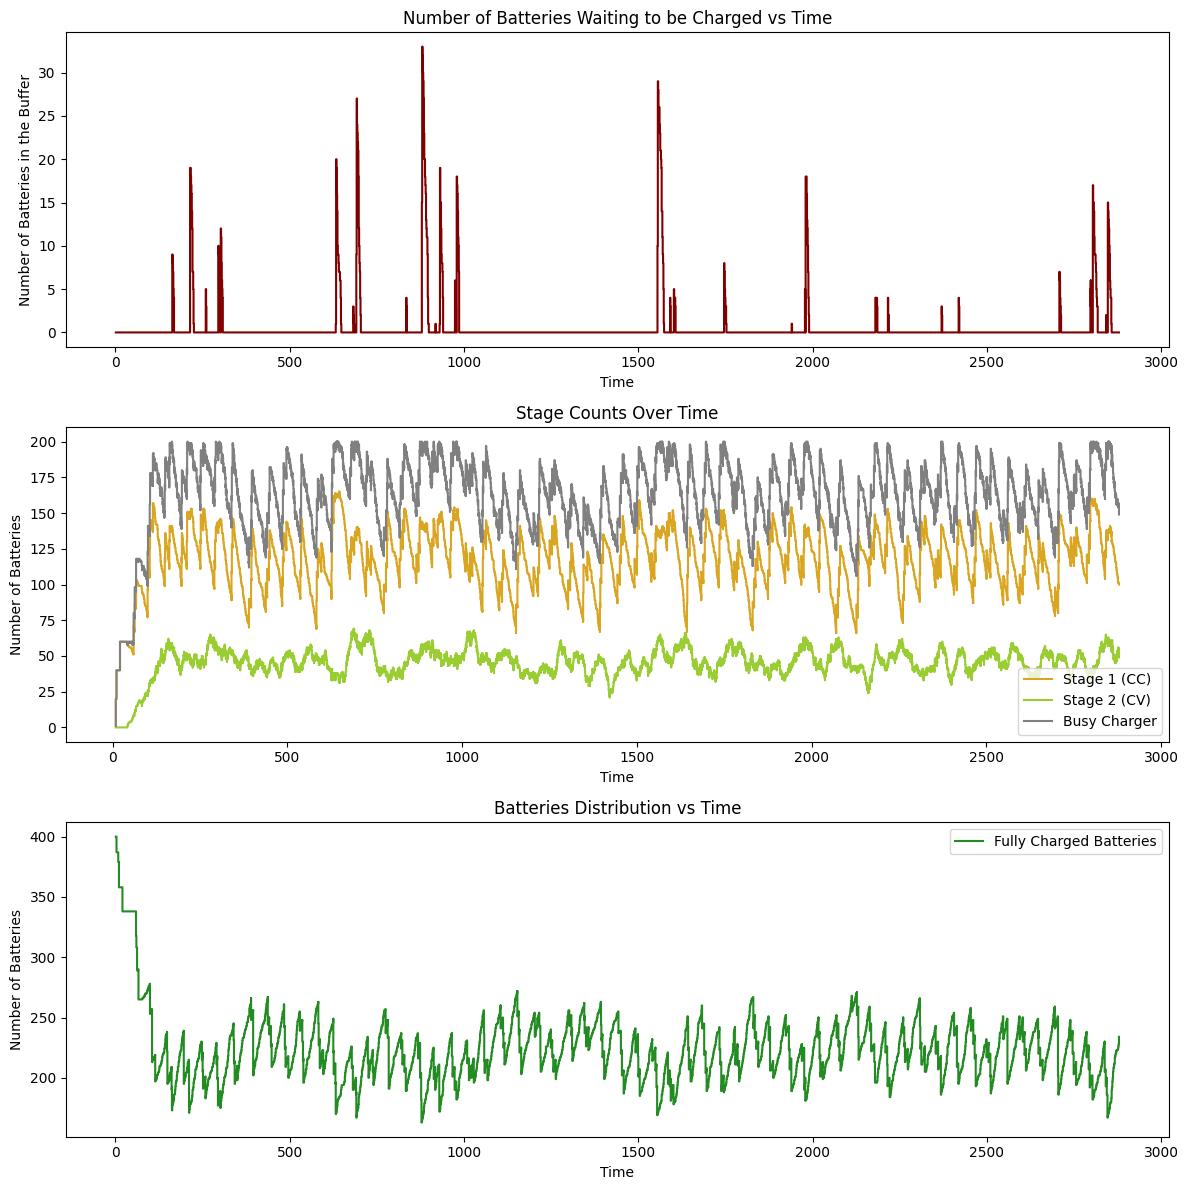

In [259]:
def plot_times(times, title):
    times.sort(key=lambda x: x[0])  # Sort by time
    plt.step(*zip(*times), where='post', color = 'maroon')
    plt.xlabel('Time')
    plt.ylabel('Number of Batteries in the Buffer')
    plt.title(title)

def plot_stage_counts(stage_counts, title):
    times, stage_1_counts, stage_2_counts, charger_counts = zip(*stage_counts)
    plt.step(times, stage_1_counts, where='post', label='Stage 1 (CC)', color = 'goldenrod')
    plt.step(times, stage_2_counts, where='post', label='Stage 2 (CV)', color = 'yellowgreen') 
    plt.step(times, charger_counts, where='post', label='Busy Charger', color = 'gray')
    plt.xlabel('Time')
    plt.ylabel('Number of Batteries')
    plt.title(title)
    plt.legend()

def plot_battery_distribution(fb_buffer_over_time, title):
    times, fb_buffer_over_time = zip(*fb_buffer_over_time)
    plt.step(times, fb_buffer_over_time, where='post', label='Fully Charged Batteries', color = 'forestgreen')

    
    plt.xlabel('Time')
    plt.ylabel('Number of Batteries')
    plt.title(title)
    plt.legend()



 
plt.figure(figsize=(12, 12))  

plt.subplot(3, 1, 1)  
plot_times(ccs_queue_over_times, 'Number of Batteries Waiting to be Charged vs Time')

plt.subplot(3, 1, 2)  
plot_stage_counts(stage_counts_over_time, 'Stage Counts Over Time')


plt.subplot(3, 1, 3)   
plot_battery_distribution(fb_buffer_over_time, 'Batteries Distribution vs Time') 

plt.tight_layout()
plt.show()  